# K리그 관중 예측 - 모델링

피처 엔지니어링 결과를 바탕으로 관중 예측 모델을 구축합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료")

라이브러리 로드 완료


---
## 1. 데이터 로드

In [2]:
# 피처 엔지니어링 결과 로드
df = pd.read_csv("..\\data\\kleague_features.csv", encoding='utf-8-sig')

print(f"데이터 크기: {df.shape}")
df.head()

데이터 크기: (4413, 35)


,Meet_Year,LEAGUE_NAME,Game_id,Game_Datetime,HomeTeam,AwayTeam,Field_Name,Round,HomeRank,AwayRank,...,points_sum,points_diff,is_good_temp,is_good_weather,temp_range,weather_encoded,is_k1,is_covid,Audience_Qty,log_audience
0,2015,K리그1,1,2015-03-07 15:00:00,전북,성남,전주 월드컵 경기장,1,6,6,...,0,0,0,1,0.0,0.0,1,0,23810,10.077903
1,2015,K리그1,2,2015-03-07 14:00:00,인천,광주,인천 축구 전용경기장,1,6,6,...,0,0,0,1,0.0,0.0,1,0,8012,8.988821
2,2015,K리그1,3,2015-03-07 16:00:00,부산,대전,부산 아시아드 경기장,1,6,6,...,0,0,0,1,0.0,0.0,1,0,9082,9.114160
3,2015,K리그1,4,2015-03-08 14:00:00,전남,제주,광양 전용 구장,1,6,6,...,0,0,0,1,1.0,0.0,1,0,12608,9.442166
4,2015,K리그1,5,2015-03-08 14:00:00,수원,포항,수원 월드컵 경기장,1,6,6,...,0,0,0,1,0.0,0.0,1,0,17573,9.774176


In [3]:
# 피처 및 타겟 정의
feature_cols = [
    'Round', 'HomeRank', 'AwayRank', 'HomePoints', 'AwayPoints',
    'Temperature', 'Humidity',
    'month', 'hour', 'is_weekend', 'season_phase', 'day_encoded',
    'home_team_popularity', 'away_team_popularity', 'is_derby',
    'rank_sum', 'rank_diff', 'is_big_match', 'points_sum', 'points_diff',
    'is_good_temp', 'is_good_weather', 'temp_range', 'weather_encoded',
    'is_k1', 'is_covid'
]

target_col = 'Audience_Qty'
log_target_col = 'log_audience'

# 결측치 제거
df_model = df.dropna(subset=feature_cols + [target_col])
print(f"모델링용 데이터: {len(df_model)}개 샘플")

X = df_model[feature_cols]
y = df_model[target_col]
y_log = df_model[log_target_col]

print(f"\n피처 수: {X.shape[1]}")
print(f"타겟 범위: {y.min():,} ~ {y.max():,}")

모델링용 데이터: 4413개 샘플

피처 수: 26
타겟 범위: 26 ~ 52,600


---
## 2. Train/Test 분할

In [4]:
# 시계열 특성을 고려하여 최근 데이터를 테스트셋으로 사용
# 2024년 이후 데이터를 테스트셋으로
train_mask = df_model['Meet_Year'] < 2024
test_mask = df_model['Meet_Year'] >= 2024

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]
y_train_log = y_log[train_mask]
y_test_log = y_log[test_mask]

print(f"Train 데이터: {len(X_train)}개 ({train_mask.sum()/len(df_model)*100:.1f}%)")
print(f"Test 데이터: {len(X_test)}개 ({test_mask.sum()/len(df_model)*100:.1f}%)")
print(f"\nTrain 연도: {df_model[train_mask]['Meet_Year'].min()} ~ {df_model[train_mask]['Meet_Year'].max()}")
print(f"Test 연도: {df_model[test_mask]['Meet_Year'].min()} ~ {df_model[test_mask]['Meet_Year'].max()}")

Train 데이터: 3446개 (78.1%)
Test 데이터: 967개 (21.9%)

Train 연도: 2015 ~ 2023
Test 연도: 2024 ~ 2025


In [5]:
# 피처 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("스케일링 완료")

스케일링 완료


---
## 3. 평가 함수 정의

In [6]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """모델 성능 평가"""
    # 예측
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 평가 지표
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # MAPE (0 제외)
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    results = {
        'model': model_name,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mape': train_mape,
        'test_mape': test_mape
    }
    
    print(f"\n{'='*50}")
    print(f"{model_name} 성능")
    print(f"{'='*50}")
    print(f"{'지표':<15} {'Train':>12} {'Test':>12}")
    print(f"{'-'*50}")
    print(f"{'RMSE':<15} {train_rmse:>12,.0f} {test_rmse:>12,.0f}")
    print(f"{'MAE':<15} {train_mae:>12,.0f} {test_mae:>12,.0f}")
    print(f"{'R2 Score':<15} {train_r2:>12.4f} {test_r2:>12.4f}")
    print(f"{'MAPE (%)':<15} {train_mape:>12.2f} {test_mape:>12.2f}")
    
    return results, y_test_pred

print("평가 함수 정의 완료")

평가 함수 정의 완료


---
## 4. 베이스라인 모델

In [7]:
# 4-1. 단순 평균 예측 (베이스라인)
y_pred_mean = np.full(len(y_test), y_train.mean())

baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_mean))
baseline_mae = mean_absolute_error(y_test, y_pred_mean)

print("베이스라인: 단순 평균 예측")
print(f"Train 평균 관중: {y_train.mean():,.0f}")
print(f"\nTest RMSE: {baseline_rmse:,.0f}")
print(f"Test MAE: {baseline_mae:,.0f}")

베이스라인: 단순 평균 예측
Train 평균 관중: 4,398

Test RMSE: 7,068
Test MAE: 4,512


In [8]:
# 4-2. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

lr_results, lr_pred = evaluate_model(lr_model, X_train_scaled, X_test_scaled, 
                                      y_train, y_test, "Linear Regression")


Linear Regression 성능
지표                     Train         Test
--------------------------------------------------
RMSE                   3,193        4,610
MAE                    2,118        2,839
R2 Score              0.6111       0.4998
MAPE (%)              103.03        37.97


In [9]:
# 4-3. Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

ridge_results, ridge_pred = evaluate_model(ridge_model, X_train_scaled, X_test_scaled,
                                            y_train, y_test, "Ridge Regression")


Ridge Regression 성능
지표                     Train         Test
--------------------------------------------------
RMSE                   3,193        4,611
MAE                    2,117        2,839
R2 Score              0.6111       0.4996
MAPE (%)              102.96        37.96


In [10]:
# 4-4. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_results, rf_pred = evaluate_model(rf_model, X_train, X_test,
                                      y_train, y_test, "Random Forest")


Random Forest 성능
지표                     Train         Test
--------------------------------------------------
RMSE                   1,587        4,462
MAE                    1,074        2,741
R2 Score              0.9040       0.5314
MAPE (%)               46.22        35.17


In [11]:
# 4-5. Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

gb_results, gb_pred = evaluate_model(gb_model, X_train, X_test,
                                      y_train, y_test, "Gradient Boosting")


Gradient Boosting 성능
지표                     Train         Test
--------------------------------------------------
RMSE                   1,630        4,460
MAE                    1,088        2,759
R2 Score              0.8987       0.5318
MAPE (%)               46.74        35.21



베이스라인 모델 비교


,model,test_rmse,test_mae,test_r2,test_mape
0,Linear Regression,4609.85,2838.88,0.50,37.97
1,Ridge Regression,4610.57,2839.34,0.50,37.96
2,Random Forest,4461.69,2741.28,0.53,35.17
3,Gradient Boosting,4459.68,2758.92,0.53,35.21


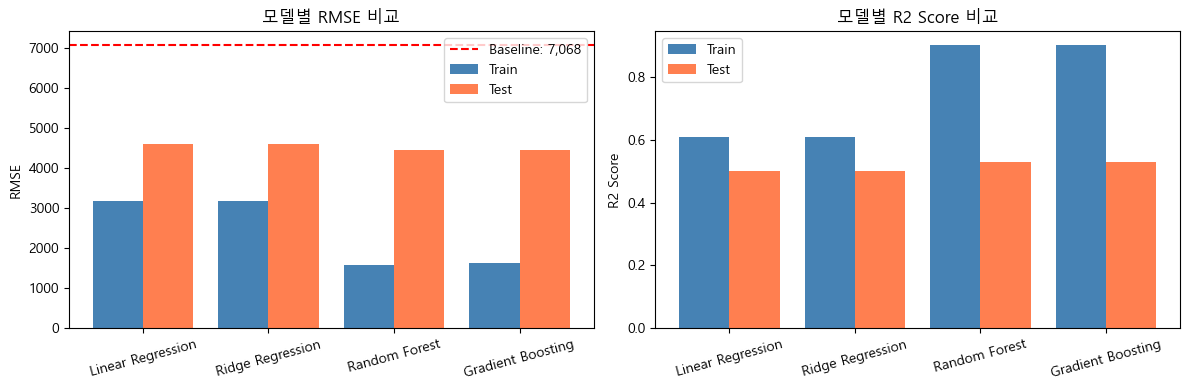

In [12]:
# 4-6. 베이스라인 모델 비교
results_df = pd.DataFrame([lr_results, ridge_results, rf_results, gb_results])
results_df = results_df.round(2)

print("\n" + "="*60)
print("베이스라인 모델 비교")
print("="*60)
display(results_df[['model', 'test_rmse', 'test_mae', 'test_r2', 'test_mape']])

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# RMSE 비교
ax1 = axes[0]
models = results_df['model']
x_pos = np.arange(len(models))
ax1.bar(x_pos - 0.2, results_df['train_rmse'], 0.4, label='Train', color='steelblue')
ax1.bar(x_pos + 0.2, results_df['test_rmse'], 0.4, label='Test', color='coral')
ax1.axhline(baseline_rmse, color='red', linestyle='--', label=f'Baseline: {baseline_rmse:,.0f}')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models, rotation=15)
ax1.set_ylabel('RMSE')
ax1.set_title('모델별 RMSE 비교')
ax1.legend()

# R2 비교
ax2 = axes[1]
ax2.bar(x_pos - 0.2, results_df['train_r2'], 0.4, label='Train', color='steelblue')
ax2.bar(x_pos + 0.2, results_df['test_r2'], 0.4, label='Test', color='coral')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, rotation=15)
ax2.set_ylabel('R2 Score')
ax2.set_title('모델별 R2 Score 비교')
ax2.legend()

plt.tight_layout()
plt.show()

---
## 5. 모델 튜닝 (Random Forest)

In [13]:
# 5-1. Random Forest 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print(f"\n최적 파라미터: {rf_grid.best_params_}")
print(f"최적 CV RMSE: {-rf_grid.best_score_:,.0f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits

최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
최적 CV RMSE: 3,258


In [14]:
# 5-2. 최적 모델 평가
rf_best = rf_grid.best_estimator_
rf_best_results, rf_best_pred = evaluate_model(rf_best, X_train, X_test,
                                                y_train, y_test, "Random Forest (Tuned)")


Random Forest (Tuned) 성능
지표                     Train         Test
--------------------------------------------------
RMSE                   1,725        4,475
MAE                    1,119        2,755
R2 Score              0.8864       0.5287
MAPE (%)               46.91        35.18


---
## 6. 모델 튜닝 (Gradient Boosting)

In [15]:
# 6-1. Gradient Boosting 하이퍼파라미터 튜닝
param_grid_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'min_samples_split': [2, 5]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

gb_grid.fit(X_train, y_train)

print(f"\n최적 파라미터: {gb_grid.best_params_}")
print(f"최적 CV RMSE: {-gb_grid.best_score_:,.0f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits

최적 파라미터: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}
최적 CV RMSE: 3,155


In [16]:
# 6-2. 최적 모델 평가
gb_best = gb_grid.best_estimator_
gb_best_results, gb_best_pred = evaluate_model(gb_best, X_train, X_test,
                                                y_train, y_test, "Gradient Boosting (Tuned)")


Gradient Boosting (Tuned) 성능
지표                     Train         Test
--------------------------------------------------
RMSE                   2,455        4,505
MAE                    1,538        2,815
R2 Score              0.7701       0.5223
MAPE (%)               62.23        34.88


---
## 7. 최종 모델 비교

In [17]:
# 7-1. 전체 모델 비교
all_results = pd.DataFrame([
    lr_results, ridge_results, rf_results, gb_results,
    rf_best_results, gb_best_results
])
all_results = all_results.sort_values('test_rmse')

print("="*70)
print("전체 모델 성능 비교 (Test RMSE 기준 정렬)")
print("="*70)
display(all_results[['model', 'test_rmse', 'test_mae', 'test_r2', 'test_mape']].round(2))

best_model_name = all_results.iloc[0]['model']
print(f"\n최적 모델: {best_model_name}")

전체 모델 성능 비교 (Test RMSE 기준 정렬)


,model,test_rmse,test_mae,test_r2,test_mape
3,Gradient Boosting,4459.68,2758.92,0.53,35.21
2,Random Forest,4461.69,2741.28,0.53,35.17
4,Random Forest (Tuned),4474.63,2755.48,0.53,35.18
5,Gradient Boosting (Tuned),4505.00,2814.67,0.52,34.88
0,Linear Regression,4609.85,2838.88,0.50,37.97
1,Ridge Regression,4610.57,2839.34,0.50,37.96



최적 모델: Gradient Boosting


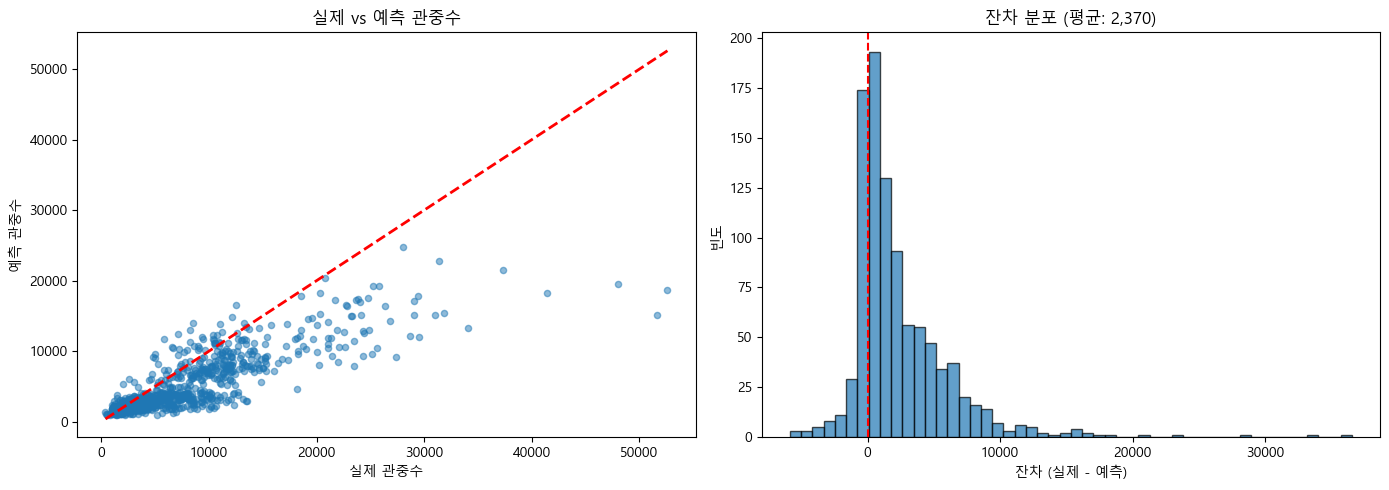

In [18]:
# 7-2. 최적 모델 예측 시각화
# Gradient Boosting (Tuned)를 최적 모델로 가정
best_model = gb_best if gb_best_results['test_rmse'] < rf_best_results['test_rmse'] else rf_best
best_pred = gb_best_pred if gb_best_results['test_rmse'] < rf_best_results['test_rmse'] else rf_best_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 실제 vs 예측
ax1 = axes[0]
ax1.scatter(y_test, best_pred, alpha=0.5, s=20)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('실제 관중수')
ax1.set_ylabel('예측 관중수')
ax1.set_title('실제 vs 예측 관중수')

# 잔차 분포
ax2 = axes[1]
residuals = y_test.values - best_pred
ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--')
ax2.set_xlabel('잔차 (실제 - 예측)')
ax2.set_ylabel('빈도')
ax2.set_title(f'잔차 분포 (평균: {residuals.mean():,.0f})')

plt.tight_layout()
plt.show()

---
## 8. 피처 중요도 분석

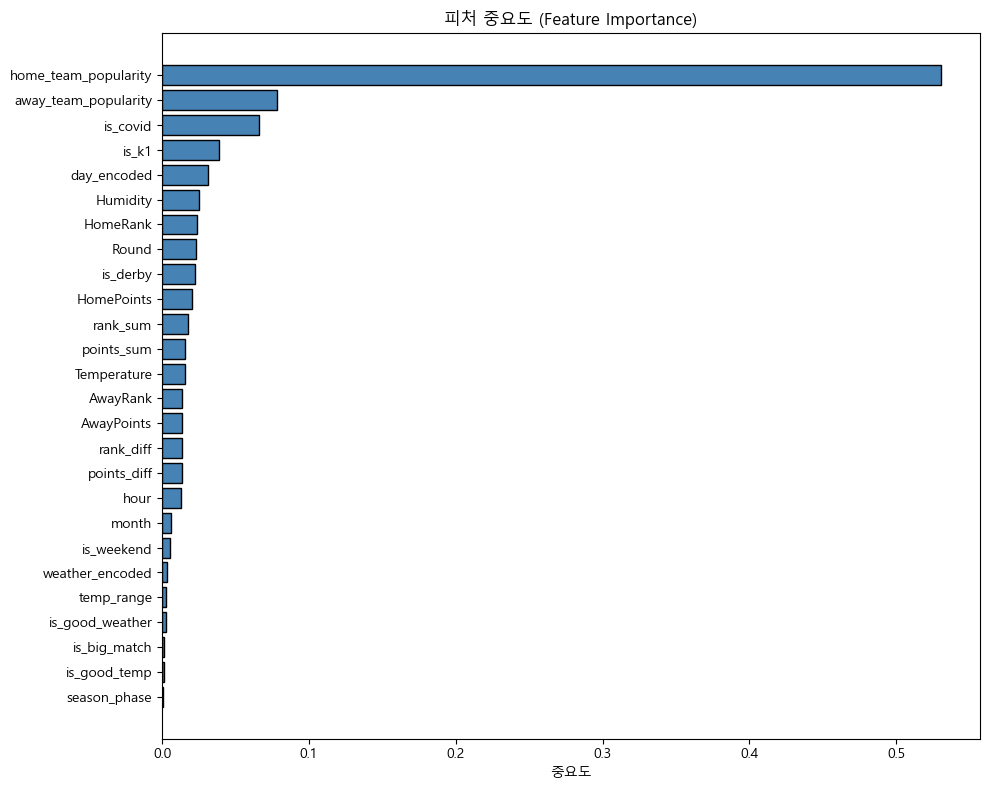


Top 10 중요 피처:


,feature,importance
12,home_team_popularity,0.530593
13,away_team_popularity,0.078407
25,is_covid,0.066303
24,is_k1,0.039085
11,day_encoded,0.031134
6,Humidity,0.025170
1,HomeRank,0.024030
0,Round,0.022895
14,is_derby,0.022278
3,HomePoints,0.020199


In [19]:
# 8-1. 피처 중요도 (Random Forest 또는 Gradient Boosting)
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(importance_df['feature'][::-1], importance_df['importance'][::-1], 
               color='steelblue', edgecolor='black')
ax.set_xlabel('중요도')
ax.set_title('피처 중요도 (Feature Importance)')
plt.tight_layout()
plt.show()

print("\nTop 10 중요 피처:")
display(importance_df.head(10))

---
## 9. 모델 저장

In [20]:
import joblib

# 최적 모델 저장
model_path = "..\\data\\best_model.pkl"
scaler_path = "..\\data\\scaler.pkl"

joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"모델 저장 완료: {model_path}")
print(f"스케일러 저장 완료: {scaler_path}")

모델 저장 완료: ..\data\best_model.pkl
스케일러 저장 완료: ..\data\scaler.pkl


In [21]:
# 최종 요약
print("="*60)
print("K리그 관중 예측 모델링 완료")
print("="*60)
print(f"\n최적 모델: {best_model_name}")
print(f"Test RMSE: {all_results.iloc[0]['test_rmse']:,.0f}")
print(f"Test MAE: {all_results.iloc[0]['test_mae']:,.0f}")
print(f"Test R2: {all_results.iloc[0]['test_r2']:.4f}")
print(f"Test MAPE: {all_results.iloc[0]['test_mape']:.2f}%")
print(f"\nTop 3 중요 피처:")
for i, row in importance_df.head(3).iterrows():
    print(f"  - {row['feature']}: {row['importance']:.4f}")

K리그 관중 예측 모델링 완료

최적 모델: Gradient Boosting
Test RMSE: 4,460
Test MAE: 2,759
Test R2: 0.5318
Test MAPE: 35.21%

Top 3 중요 피처:
  - home_team_popularity: 0.5306
  - away_team_popularity: 0.0784
  - is_covid: 0.0663
